In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<center>
<form action="javascript:code_toggle()"><input type="submit" value="Show/Hide Code"></form>''')


Overview
===
In this script I'll be exploring a Pokemon dataset compiled from Serebii.net with information like base stat totals (the sum of all individual stats for a Pokemon), Pokemon names, height/weight, type, etc.

First I'll be cleaning the dataset, then exploring it, then creating a classification model to predict whether a Pokemon with certain traits is a legendary.

The button at the top will show/hide code. Hiding makes it like a presentation, while showing lets you see what's going on behind the scenes. If you just care about how I write code, ignore the Markdown cells.

In [3]:
#import always-necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

sb.set(style = "darkgrid", font_scale =1.2)

%matplotlib inline

Data Cleaning
===

Cleaning this data involved fixing column titles, checking for invalid (for our purposes) records, and generally checking for dataset issues. Click the *Show Code* button for more details!

First we read in the dataset and check the structure.

In [4]:
df = pd.read_csv("Data/pokemon.csv")
df.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


The structure of the dataset seems to make sense, although we have no idea of overall dataset size or what all the columns are yet.

In [5]:
print(df.shape)
print(df.columns)

(801, 41)
Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')


We can see that the column names are already detailed and sensible, except one is misspelled! That's a quick fix though.

In [6]:
df.rename(columns = {'classfication':'classification'}, inplace=True)
print(df.columns)

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classification', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')


Although with large datasets we can't spot-check every record, we can still try and find trouble records. One easy way is making sure pandas ingested columns as we expected.

In [7]:
print(df.dtypes)

abilities             object
against_bug          float64
against_dark         float64
against_dragon       float64
against_electric     float64
against_fairy        float64
against_fight        float64
against_fire         float64
against_flying       float64
against_ghost        float64
against_grass        float64
against_ground       float64
against_ice          float64
against_normal       float64
against_poison       float64
against_psychic      float64
against_rock         float64
against_steel        float64
against_water        float64
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate          object
classification        object
defense                int64
experience_growth      int64
height_m             float64
hp                     int64
japanese_name         object
name                  object
percentage_male      float64
pokedex_number         int64
sp_attack              int64
sp_defense    

Most dtypes makes sense, except I expected capture_rate to be an int64. To find the records that pandas didn't detect as an int, we can try and convert it to a numeric type.

Running *`pd.to_numeric(df.capture_rate)`* yields the error message *`Unable to parse string "30 (Meteorite)255 (Core)" at position 773`*. This Pokemon (Minior) has two separate capture_rates, so we can edit the record to just include the core capture rate.

In [8]:
df.loc[773,"capture_rate"] = 255


print("The new capture_rate is %i." %df.loc[773, "capture_rate"])

The new capture_rate is 255.


Now we have, as far as we can tell, a pretty clean dataset. That means we get to have fun!

Data Exploration
===

First I want to find out which type has the highest stat total, then which Pokemon have the highest stat totals, and finally which type has the greatest overall effectiveness vs. the Pokemon in the dataset.

In [9]:
#Average each type's base stat totals, rank descending

base_by_type = df.groupby('type1').base_total.mean().reset_index()
base_by_type.sort_values('base_total', ascending=False)

,type1,base_total
2,dragon,522.777778
16,steel,491.583333
14,psychic,461.264151
7,flying,453.333333
6,fire,450.634615
1,dark,449.758621
15,rock,447.266667
3,electric,436.153846
8,ghost,434.703704
11,ice,433.608696


In [10]:
#Rank base stat totals of all Pokemon in the dataset, take top 10

df[['name','base_total']].sort_values('base_total', ascending=False).head(10)

,name,base_total
149,Mewtwo,780
383,Rayquaza,780
382,Groudon,770
381,Kyogre,770
492,Arceus,720
717,Zygarde,708
380,Latios,700
372,Salamence,700
247,Tyranitar,700
444,Garchomp,700


In [11]:
#Filter dataset to just all the "against" columns
against = df.filter(regex='against.*')

#Sum these, name the columns
against_sums = against.sum().reset_index()
against_sums.columns = ('type','sum')

#Rank, show all 18 types
against_sums.sort_values('sum', ascending=False, inplace=True)
against_sums.head(18)

,type,sum
15,against_rock,1001.50
11,against_ice,967.75
7,against_flying,955.50
6,against_fire,909.50
10,against_ground,879.50
3,against_electric,860.25
4,against_fairy,856.25
5,against_fight,853.50
17,against_water,847.75
1,against_dark,846.75


Unsurprisingly, *dragon is the type with the highest average base stat total*, with *bug being the lowest*. The preponderance of dragon-type legendaries and the prevalence of completely inconsequential tiny bugs in every generation make this outcome fairly predictable.

It's also not surprising that *Mewtwo* sits atop the pile in terms of base stats, but this ranking reveals an unfortunate characteristic of this data-set: it doesn't distinguish between different forms of the same Pokemon-- each Pokemon receives the stats of its highest-stat form. We see "Groudon" here when in reality, only "Primal Groudon" has a base stat total of 770. We also see "Salamence," "Tyranitar," and "Garchomp" in the top 10, when only their Mega Evolutions possess these stat totals. This is something to keep in mind moving forward, but as all legendary Pokemon have further evolutions that are also legendary (Kyogre, Groudon, etc.), I expect this to affect our upcoming model minimally.

Finally, we also see that *Rock type is the most effective vs. the entire field of Pokemon*. Given that Rock is super-effective against the extremely prevalent Flying type, as well as Ice, Fire, and Bug (remember all those little bugs from before?), this is not wholly surprising. Way at the bottom we have normal, which is hurt in this ranking both by its 0x multiplier against Ghosts and not being super-effective against any other type.

**Other Questions**

**(1) It feels like Pokemon got progressively better from generation to generation. Is this true?**

One potential way to measure this is the progression of average base stat total-- let's check!

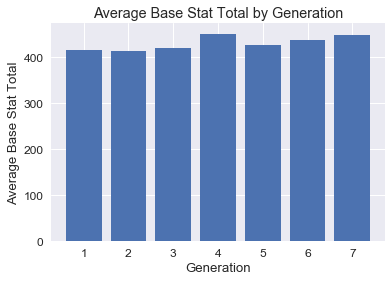

In [12]:
base_by_gen = df.groupby('generation').base_total.mean().reset_index()

plt.bar(base_by_gen.generation, base_by_gen.base_total)
plt.ylabel('Average Base Stat Total')
plt.xlabel('Generation')
plt.title('Average Base Stat Total by Generation');

Actually, the average base stat total looks very similar from generation to generation, with a small peak at Gen. 4. However, maybe it's just that the top-level competitive Pokemon get better? Let's restrict to top 50 and see how that changes things.

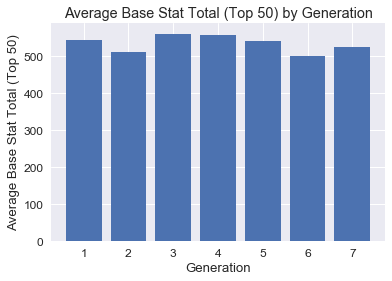

In [13]:
top50_by_gen = df.groupby('generation').base_total.nlargest(50).reset_index()
avg_by_gen = top50_by_gen.groupby('generation').mean().reset_index()

plt.bar(avg_by_gen.generation, avg_by_gen.base_total)
plt.ylabel('Average Base Stat Total (Top 50)')
plt.xlabel('Generation')
plt.title('Average Base Stat Total (Top 50) by Generation');

How about the top 10?

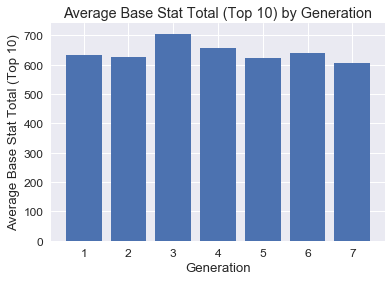

In [14]:
top10_by_gen = df.groupby('generation').base_total.nlargest(10).reset_index()
avg_by_gen = top10_by_gen.groupby('generation').mean().reset_index()

plt.bar(avg_by_gen.generation, avg_by_gen.base_total)
plt.ylabel('Average Base Stat Total (Top 10)')
plt.xlabel('Generation')
plt.title('Average Base Stat Total (Top 10) by Generation');

Now we finally see a generation pull ahead noticeably. Which Pokemon are sitting in this top 10, though?

In [15]:
df[df["generation"] == 3][["name","base_total"]].sort_values(
    "base_total", ascending=False).head(10)

,name,base_total
383,Rayquaza,780
382,Groudon,770
381,Kyogre,770
375,Metagross,700
380,Latios,700
379,Latias,700
372,Salamence,700
288,Slaking,670
259,Swampert,635
253,Sceptile,630


Looks like the top 3 are what cause Gen. 3 to pull ahead so far. All of the big legendaries of Gen. 3 got "Primal" versions, which happen to all be in the top 4 Pokemon overall stat-wise.

**(2) How did the type composition change across generations?**

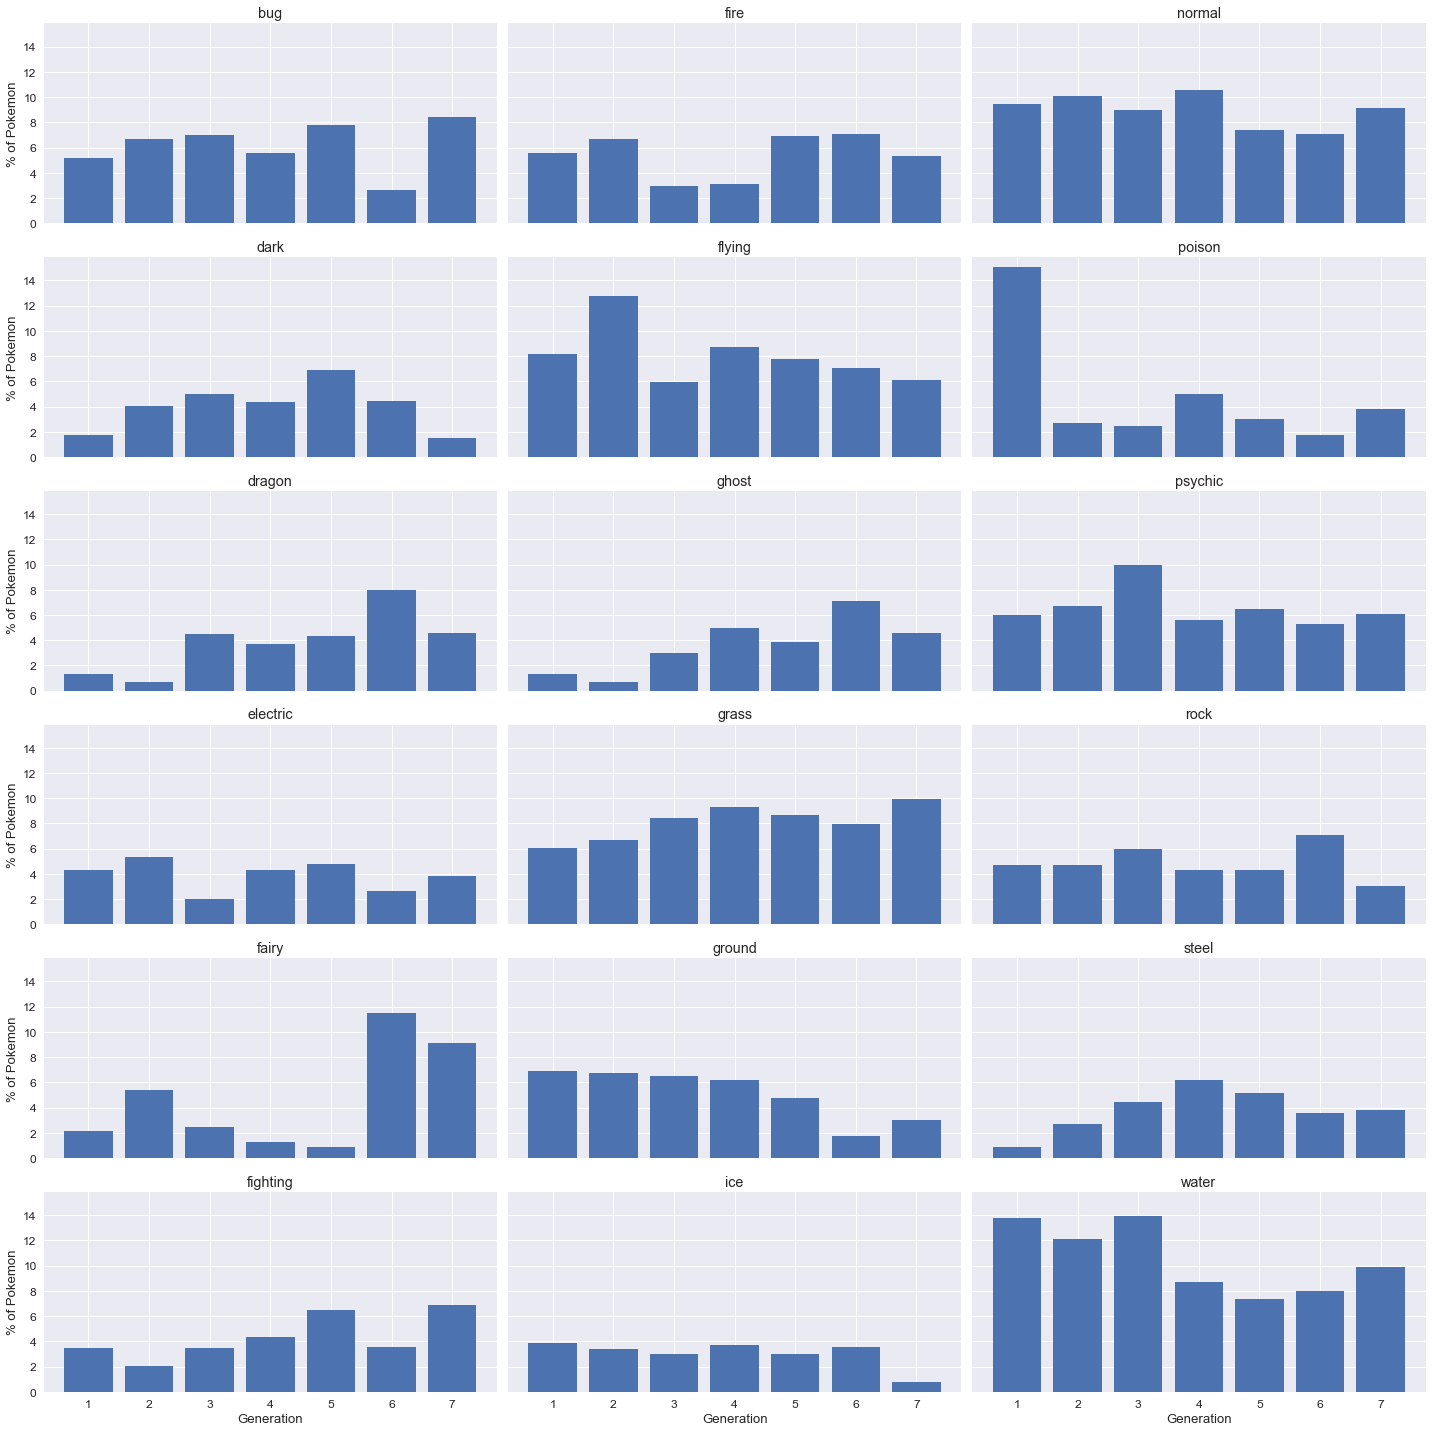

In [16]:
type1 = df[['generation','type1']]
type1.columns = ['generation','type']
type2 = df[['generation','type2']]
type2.columns = ['generation','type']
all_types = type1.append(type2)

all_types.dropna(inplace=True)

typelist = sorted(all_types.type.unique())

i = 0
j = 0

fig, axes = plt.subplots(6,3, figsize = (20,20), sharey=True, sharex=True)

for item in typelist:
    y = 100 * all_types[all_types['type']==item].groupby('generation').count().reset_index()
    totals = all_types.groupby('generation').count().reset_index()
    totals['perc'] = y['type']/totals['type']
    axes[i,j].bar(totals.generation,totals.perc)
    axes[i,j].set_title('%s' %item)
    if j == 0:
        axes[i,j].set_ylabel('% of Pokemon')
    if i < 5:
        i+=1
    else:
        axes[i,j].set_xlabel('Generation')
        i = 0
        j+=1

        
plt.tight_layout()

There are some interesting trends here that I'll mostly leave for visual interpretation (double click on the plots to zoom in), but I will call out how much Gen. 7 hated ice types, and how much Gen. 1 loved poison!

**(3) What features define legendary Pokemon?**

One of the quickest and most sound ways of seeing what features define a certain classification is to model that classification! Creating a classification model is relatively simple in Python, although we need to be careful with our particular dataset. Anytime one outcome is more likely than the other (here, there are way more non-legendaries than legendaries in our dataset), you have an "imbalanced" dataset. Because of this, we need to make sure that:
a. Our training and testing set both contain entries for the minority class
b. Our training and testing set both contain approximately the same proportion of entries for the minority class
c. Our model is not just predicting the majority class
d. We use modeling methods that can handle imbalanced datasets.

For now, I run through classification without much explanation, and will hopefully return here to flesh out the explanation and the model later. This model is extremely simplistic, but luckily, Random Forest often handles classification on imbalanced data extremely well, and gives us a peek under the hood through the "importance matrix." I am also hoping to add actual scoring of the model beyond just accuracy, as accuracy isn't a particularly useful metric in imbalanced datasets.

In [25]:
#Get model ready for classification
cols = ['attack', 'capture_rate', 'defense', 'experience_growth', 'hp',
        'sp_attack', 'sp_defense', 'speed','type1', 'is_legendary']

In [30]:
#Classification
from sklearn.model_selection import train_test_split

train, test = train_test_split(pd.get_dummies(df[cols], columns=['type1']),
                               test_size = 0.3, random_state = 10)

print(train.shape)
print(test.shape)
print(train[train["is_legendary"]==1].shape)
print(test[test["is_legendary"]==1].shape)

(560, 27)
(241, 27)
(46, 27)
(24, 27)


In [31]:
from sklearn.ensemble import RandomForestClassifier

y = train.is_legendary
X = train.drop('is_legendary', axis=1)

clf = RandomForestClassifier(random_state = 10)
clf.fit(X,y)
pred_y = clf.predict(X)

In [32]:
print(np.unique(pred_y))

[0 1]


0.996428571429
{'feature': Index(['attack', 'capture_rate', 'defense', 'experience_growth', 'hp',
       'sp_attack', 'sp_defense', 'speed', 'type1_bug', 'type1_dark',
       'type1_dragon', 'type1_electric', 'type1_fairy', 'type1_fighting',
       'type1_fire', 'type1_flying', 'type1_ghost', 'type1_grass',
       'type1_ground', 'type1_ice', 'type1_normal', 'type1_poison',
       'type1_psychic', 'type1_rock', 'type1_steel', 'type1_water'],
      dtype='object'), 'importance': [0.076561883929233784, 0.3943130268933745, 0.049125049767183217, 0.16525096500573669, 0.032918026333051013, 0.1199565536542417, 0.038022922685264873, 0.066070938830498693, 0.0044166307181040514, 0.00054726604637014647, 6.1920668566314635e-06, 0.00052610588139303366, 0.0037490765257755564, 0.0, 0.0, 0.0, 0.00023799599814136393, 0.0042050822560949549, 0.0027565733672603896, 0.0015483942322314845, 0.0065362218973345331, 0.0, 0.022916151197450656, 0.0024465586153605496, 0.0057672880019394345, 0.0021210960971026734]}

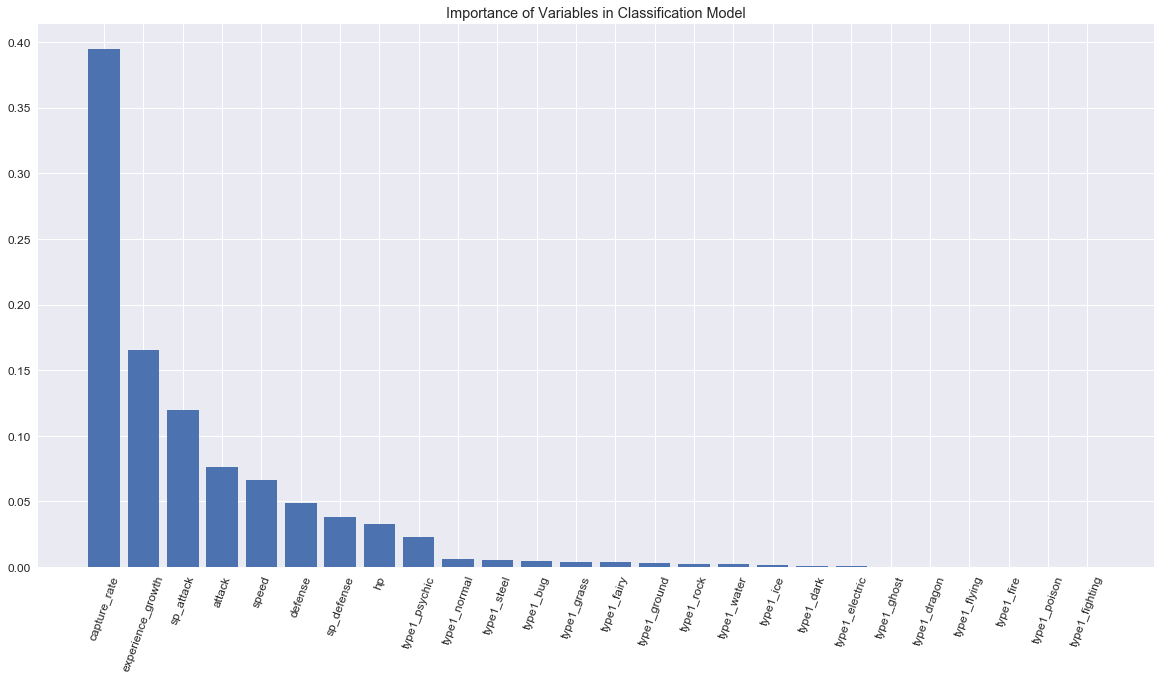

In [33]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y, pred_y))

featuresdict = {"feature":X.columns, "importance":list(clf.feature_importances_)}
print(featuresdict)

featuresdf = pd.DataFrame.from_dict(featuresdict)

featuresdf.head()
featuresdf.sort_values("importance", ascending=False, inplace = True)
featuresdf.head()

fig, ax = plt.subplots(figsize = (20,10), )
ax.set_title("Importance of Variables in Classification Model")
ax.bar(np.arange(len(featuresdf)), featuresdf.importance)
ax.set_xticks(np.arange(len(list(featuresdf.values))))
ax.set_xticklabels(featuresdf.feature, rotation = 70);

In [35]:
y_test = test.is_legendary
X_test = test.drop('is_legendary', axis = 1)


X_test.shape

pred_test_y = clf.predict(X_test)

In [52]:
print(np.unique(pred_test_y))
print(accuracy_score(y_test, pred_test_y))

[0 1]
0.958506224066
